In [173]:
import torch
from scripts import dog_breed
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import pandas as pd
import seaborn as sns
import os
from torchvision.datasets import ImageFolder
import shutil
%matplotlib inline

#### Train dataset curation

In [266]:
specified_breeds = ['beagle', 'border_collie', 'boxer', 'chihuahua', 'chow', 
                    'cocker_spaniel', 'doberman', 'english_setter', 'french_bulldog', 'giant_schnauzer', 
                    'great_dane', 'labrador_retriever', 
                    'malinois', 'maltese_dog', 'miniature_pinscher', 'pekinese', 
                    'pomeranian', 'pug', 'rottweiler', 'saint_bernard', 'samoyed', 
                    'shih-tzu', 'siberian_husky', 'toy_poodle', 'yorkshire_terrier']

In [267]:
source_folder = 'stanford_dogs/images/Images/'
target_folder = 'filtered_dataset/train'

if not os.path.exists(target_folder):
    os.makedirs(target_folder)

dataset = ImageFolder(root=source_folder)

for idx, (image_path, label) in enumerate(dataset.imgs):
    breed_name = dataset.classes[label].split('-', 1)[-1].lower()
    if breed_name in specified_breeds:
        breed_folder = os.path.join(target_folder, breed_name)
        if not os.path.exists(breed_folder):
            os.makedirs(breed_folder)
        shutil.copy(image_path, breed_folder)

In [268]:
dataset = ImageFolder('filtered_dataset/train/')

In [269]:
all_breeds = dataset.classes

print("Total number of breeds:", len(all_breeds))
print("List of all breeds:")
print(all_breeds)

Total number of breeds: 25
List of all breeds:
['beagle', 'border_collie', 'boxer', 'chihuahua', 'chow', 'cocker_spaniel', 'doberman', 'english_setter', 'french_bulldog', 'giant_schnauzer', 'great_dane', 'labrador_retriever', 'malinois', 'maltese_dog', 'miniature_pinscher', 'pekinese', 'pomeranian', 'pug', 'rottweiler', 'saint_bernard', 'samoyed', 'shih-tzu', 'siberian_husky', 'toy_poodle', 'yorkshire_terrier']


In [270]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size


train_size, val_size, test_size

(2755, 306, 1311)

In [271]:
breeds = []

def rename(name):
    return name.split('-', 1)[-1].lower()

for n in dataset.classes:
    breeds.append(rename(n))

In [272]:
breeds

['beagle',
 'border_collie',
 'boxer',
 'chihuahua',
 'chow',
 'cocker_spaniel',
 'doberman',
 'english_setter',
 'french_bulldog',
 'giant_schnauzer',
 'great_dane',
 'labrador_retriever',
 'malinois',
 'maltese_dog',
 'miniature_pinscher',
 'pekinese',
 'pomeranian',
 'pug',
 'rottweiler',
 'saint_bernard',
 'samoyed',
 'tzu',
 'siberian_husky',
 'toy_poodle',
 'yorkshire_terrier']

In [273]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(2755, 306, 1311)

In [274]:
train_ds[0]

(<PIL.Image.Image image mode=RGB size=500x400>, 5)

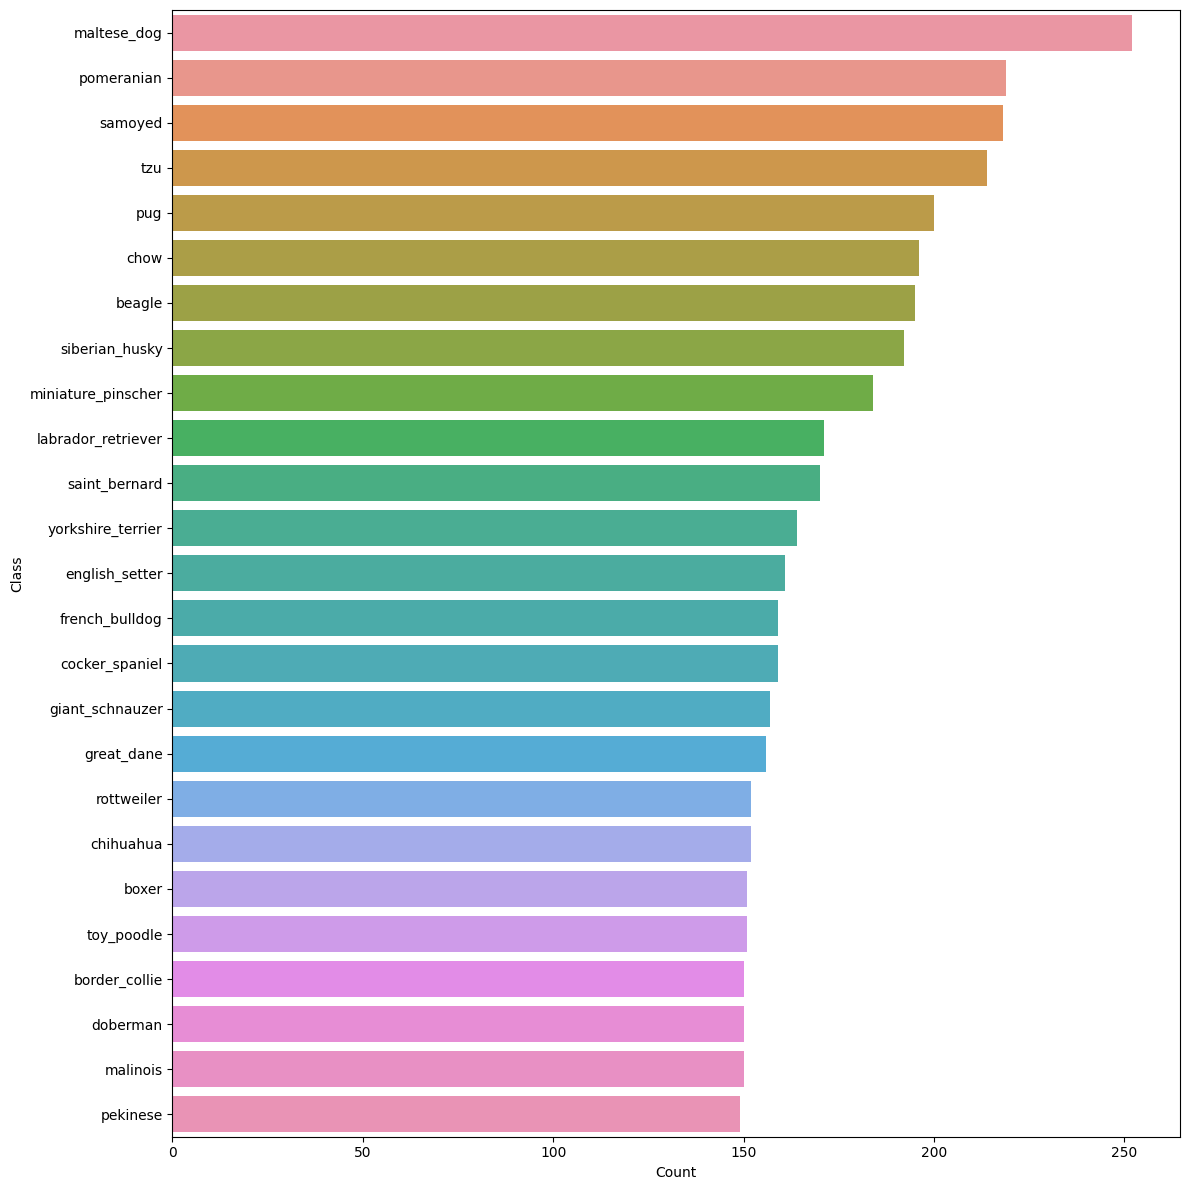

In [275]:
class_names = breeds
class_count = [dataset.targets.count(i) for i in range(len(class_names))]
df = pd.DataFrame({"Class": class_names, "Count": class_count}).sort_values(by='Count', ascending=False)

plt.figure(figsize=(12, 12), dpi=100)
sns.barplot(x="Count", y="Class", data=df)
plt.tight_layout()
plt.show()

##### DataLoader

In [276]:

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])

In [277]:
train_dataset = dog_breed.DogBreedDataset(train_ds, train_transform)
val_dataset = dog_breed.DogBreedDataset(val_ds, val_transform)
test_dataset = dog_breed.DogBreedDataset(test_ds, test_transform)

batch_size = 16

train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size*2)
test_dl = DataLoader(test_dataset, batch_size*2)

10


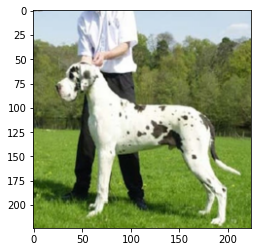

In [278]:
img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

##### Train loop

In [279]:
import torchvision.models as models
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    
num_classes = len(breeds)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, betas=(0.9, 0.99), eps=1e-08, weight_decay=1e-5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 5
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    dog_breed.train_one_epoch(model, train_dl, criterion, optimizer, device)
    dog_breed.test_model(model, test_dl, criterion, device)


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5


100%|██████████| 173/173 [00:09<00:00, 17.83it/s]


Train Loss: 1.7008 Acc: 0.5898
Test Loss: 0.7513 Acc: 0.8207
Epoch 2/5


100%|██████████| 173/173 [00:09<00:00, 17.97it/s]


Train Loss: 0.7104 Acc: 0.8316
Test Loss: 0.5529 Acc: 0.8459
Epoch 3/5


100%|██████████| 173/173 [00:10<00:00, 16.94it/s]


Train Loss: 0.5322 Acc: 0.8544
Test Loss: 0.4426 Acc: 0.8741
Epoch 4/5


100%|██████████| 173/173 [00:09<00:00, 18.63it/s]


Train Loss: 0.4408 Acc: 0.8762
Test Loss: 0.4287 Acc: 0.8703
Epoch 5/5


100%|██████████| 173/173 [00:09<00:00, 18.15it/s]


Train Loss: 0.3790 Acc: 0.8868
Test Loss: 0.3914 Acc: 0.8810


#### Test on scrapped dataset

In [296]:
specified_breeds = ['beagle', 'border_collie', 'boxer', 'chihuahua', 'chow', 
                    'cocker_spaniel', 'doberman', 'english_setter', 'french_bulldog', 'giant_schnauzer', 
                    'great_dane', 'labrador_retriever', 
                    'malinois', 'maltese_dog', 'miniature_pinscher', 'pekinese', 
                    'pomeranian', 'pug', 'rottweiler', 'saint_bernard', 'samoyed', 
                    'shih_tzu', 'siberian_husky', 'toy_poodle', 'yorkshire_terrier']

In [297]:
source_folder = 'breed_dataset/dog/'
target_folder = 'filtered_dataset/test'

if not os.path.exists(target_folder):
    os.makedirs(target_folder)

dataset = ImageFolder(root=source_folder)

for idx, (image_path, label) in enumerate(dataset.imgs):
    breed_name = dataset.classes[label].split('-', 1)[-1].lower()
    if breed_name in specified_breeds:
        breed_folder = os.path.join(target_folder, breed_name)
        if not os.path.exists(breed_folder):
            os.makedirs(breed_folder)
        shutil.copy(image_path, breed_folder)

In [298]:
test_data_scrap = ImageFolder('filtered_dataset/test')

In [299]:
all_breeds = test_data_scrap.classes

print("Total number of breeds:", len(all_breeds))
print("List of all breeds:")
print(all_breeds)

Total number of breeds: 25
List of all breeds:
['beagle', 'border_collie', 'boxer', 'chihuahua', 'chow', 'cocker_spaniel', 'doberman', 'english_setter', 'french_bulldog', 'giant_schnauzer', 'great_dane', 'labrador_retriever', 'malinois', 'maltese_dog', 'miniature_pinscher', 'pekinese', 'pomeranian', 'pug', 'rottweiler', 'saint_bernard', 'samoyed', 'shih_tzu', 'siberian_husky', 'toy_poodle', 'yorkshire_terrier']


In [300]:
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])

batch_size = 8
test_dataset_scrap = dog_breed.DogBreedDataset(test_data_scrap, test_transform)
test_dl_scrap = DataLoader(test_dataset_scrap, batch_size*2)

def create_confusion_matrix(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    confusion = confusion_matrix(all_labels, all_predictions)
    return confusion

confusion_matrix_all_classes = create_confusion_matrix(model, test_dl_scrap)



  0%|          | 0/137 [00:00<?, ?it/s]

In [301]:
total_samples = len(test_dataset_scrap)
correct_predictions = sum(confusion_matrix_all_classes[i][i] for i in range(len(confusion_matrix_all_classes)))
accuracy = correct_predictions / total_samples

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 58.36%


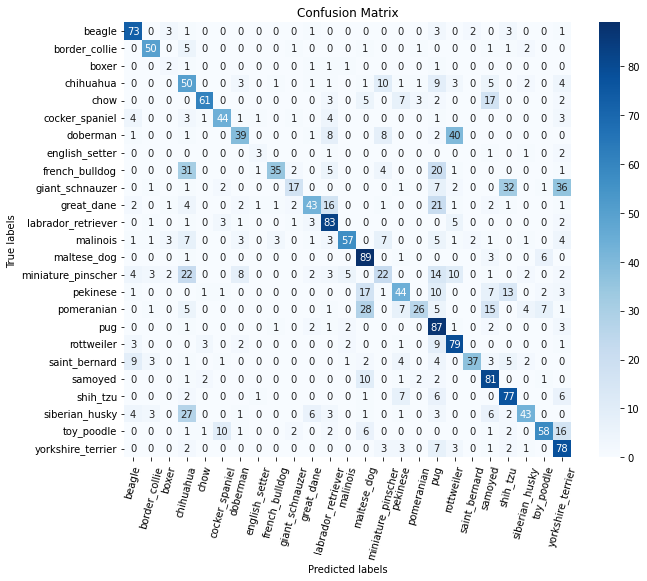

In [302]:
def plot_confusion_matrix(confusion_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=75)
    plt.yticks(rotation=0)
    plt.show()

plot_confusion_matrix(confusion_matrix_all_classes, specified_breeds)